# Bingo Tutorial 5: Benchmarking Symbolic Regression

## Goal: Compare the performance of two optimization approaches on a set of symbolic regression benchmarks

### Benchmarks in Bingo

There are several symbolic regression benchmarks included within Bingo.  These benchmarks can be used to compare the effect of different evolutionary approaches.  
Every benchmark in Bingo contains information about the benchmark (e.g., name, descritpion, source) as well as training and testing data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bingo.symbolic_regression.benchmarking.benchmark_definitions import bench_koza_1

koza_benchmark = bench_koza_1()
print("Benchmark Name:", koza_benchmark.name)
print("Description:", koza_benchmark.description)
print("Source:", koza_benchmark.source)

plt.plot(koza_benchmark.training_data.x, koza_benchmark.training_data.y, 
         'b.', label='training_data')
plt.plot(koza_benchmark.test_data.x, koza_benchmark.test_data.y, 
         'r.', label='training_data')
plt.legend()
plt.show()

Benchmark Name: Koza-1
Description: The polynomial x^4 + x^3 + x^2 + x
Source: J.R. Koza. Genetic Programming: On the Programming of Computers by Means of Natural selection. MIT Press 1992


<Figure size 640x480 with 1 Axes>

### Benchmark Suites

In Bingo a `BenchmarkSuite` is a collection of benchmarks that allows for easy filtering of all the included benchmarks and automatic testing of an evolutionary strategy.

In [2]:
from bingo.symbolic_regression.benchmarking.benchmark_suite import BenchmarkSuite

suite = BenchmarkSuite(inclusive_terms=["Koza"])

for benchmark in suite:
    print(benchmark.name, "\t", benchmark.description)

Koza-1 	 The polynomial x^4 + x^3 + x^2 + x
Koza-2 	 The polynomial x^5 - 2x^3 + x
Koza-3 	 The polynomial x^6 - 2x^4 + x^2


### Benchmark tests

In order to take advantage of the automatic testing of a evolutionary strategy.  The strategy and desired scoring must be defined in the form of a `BenchmarkTest`.  

The benchmark test uses two functions to define its behavior.  The first defines the evolutionary strategy, i.e., how to get the best individual as a function of the training data.  The example given here uses an evolutionary optimization very similar to the one in Tutorial 4.

In [11]:
from bingo.symbolic_regression.agraph.component_generator import ComponentGenerator
from bingo.symbolic_regression.agraph.generator import AGraphGenerator
from bingo.symbolic_regression.agraph.crossover import AGraphCrossover
from bingo.symbolic_regression.agraph.mutation import AGraphMutation
from bingo.symbolic_regression.explicit_regression import ExplicitRegression
from bingo.local_optimizers.continuous_local_opt import ContinuousLocalOptimization
from bingo.evaluation.evaluation import Evaluation
from bingo.evolutionary_algorithms.age_fitness import AgeFitnessEA
from bingo.evolutionary_optimizers.island import Island

from bingo.symbolic_regression.agraph import agraph as agraph_module

print(agraph_module.Backend.is_cpp())

def training_function_af(training_data):
    component_generator = ComponentGenerator(input_x_dimension=training_data.x.shape[1])
    component_generator.add_operator("+")
    component_generator.add_operator("-")
    component_generator.add_operator("*")

    agraph_generator = AGraphGenerator(agraph_size=16, 
                                       component_generator=component_generator)

    crossover = AGraphCrossover(component_generator)
    mutation = AGraphMutation(component_generator)

    fitness = ExplicitRegression(training_data=training_data)
    local_opt_fitness = ContinuousLocalOptimization(fitness, algorithm='lm')
    evaluator = Evaluation(local_opt_fitness)

    POPULATION_SIZE = 32
    MUTATION_PROBABILITY = 0.4
    CROSSOVER_PROBABILITY = 0.4

    ea = AgeFitnessEA(evaluator, agraph_generator, crossover, mutation, 
                      MUTATION_PROBABILITY, CROSSOVER_PROBABILITY, POPULATION_SIZE)


    island = Island(ea, agraph_generator, POPULATION_SIZE)

    opt_result = island.evolve_until_convergence(max_generations=400,
                                                 fitness_threshold=1e-6)

    return island.get_best_individual(), opt_result

False


The second function is a function that will be used to score how well an the strategy performed.  In the example used here, we are scoring the strategy based on fitness (mean absolute error) and sucessful convergence.

In [4]:
def scoring_function(equation, scoring_data, opt_result):
    mae_function = ExplicitRegression(training_data=scoring_data)
    mae = mae_function(equation)
    return mae, opt_result.success

Combining the above two functions gives the `BenchmarkTest` which can be used by the `BenchmarkSuite`

In [5]:
from bingo.symbolic_regression.benchmarking.benchmark_test import BenchmarkTest

age_fitness_strategy = BenchmarkTest(training_function_af, scoring_function)
train_scores_af, test_scores_af = suite.run_benchmark_test(age_fitness_strategy,
                                                           repeats=3)

Scores for the benchmarks on both their training and test datasets are the result.  One set of scores is given for each of the 4 repeats so that statistical measures can be used for comparison.

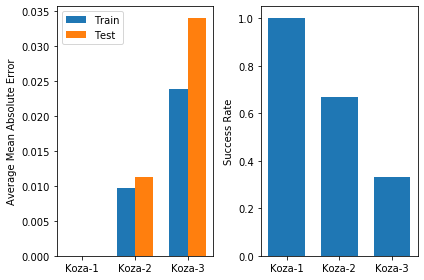

In [6]:
# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2)

mae_test_af = []
mae_train_af = []
success_rate_af = []
for train, test in zip(train_scores_af, test_scores_af):
    avg_train = np.mean(np.array(train), axis=0)
    avg_test = np.mean(np.array(test), axis=0)
    mae_train_af.append(avg_train[0])
    success_rate_af.append(avg_train[1])
    mae_test_af.append(avg_test[0])
    
labels = [bench.name for bench in suite]
label_locations = np.arange(len(labels))
bar_width = 0.35
_ = ax1.bar(label_locations - bar_width/2, mae_train_af, bar_width, label='Train')
_ = ax1.bar(label_locations + bar_width/2, mae_test_af, bar_width, label='Test')
_ = ax2.bar(label_locations, success_rate_af, bar_width*2)

ax1.set_ylabel('Average Mean Absolute Error')
ax1.set_xticks(label_locations)
ax1.set_xticklabels(labels)
ax1.legend()
ax2.set_ylabel('Success Rate')
ax2.set_xticks(label_locations)
ax2.set_xticklabels(labels)
fig.tight_layout()

### Comparing to another strategy

By creating a new training function and rerunning the benchmarks, we can compare the above evolutionary strategy (which uses age-fitness EA) to one  that uses deterministic crowding. 

Note that only the EA portion of the following function is different than the training function above.

In [7]:
from bingo.evolutionary_algorithms.deterministic_crowding import DeterministicCrowdingEA

def training_function_dc(training_data):
    component_generator = ComponentGenerator(input_x_dimension=training_data.x.shape[1])
    component_generator.add_operator("+")
    component_generator.add_operator("-")
    component_generator.add_operator("*")

    agraph_generator = AGraphGenerator(agraph_size=16, 
                                       component_generator=component_generator)

    crossover = AGraphCrossover(component_generator)
    mutation = AGraphMutation(component_generator)

    fitness = ExplicitRegression(training_data=training_data)
    local_opt_fitness = ContinuousLocalOptimization(fitness, algorithm='lm')
    evaluator = Evaluation(local_opt_fitness)

    POPULATION_SIZE = 32
    MUTATION_PROBABILITY = 0.4
    CROSSOVER_PROBABILITY = 0.4

    ea = DeterministicCrowdingEA(evaluator, crossover, mutation, 
                                 MUTATION_PROBABILITY, CROSSOVER_PROBABILITY)


    island = Island(ea, agraph_generator, POPULATION_SIZE)

    opt_result = island.evolve_until_convergence(max_generations=400,
                                                 fitness_threshold=1e-6)

    return island.get_best_individual(), opt_result

now rerun the benchmark suite with the new strategy

In [8]:
deterministic_crowding_strategy = BenchmarkTest(training_function_dc, scoring_function)
train_scores_dc, test_scores_dc = suite.run_benchmark_test(deterministic_crowding_strategy,
                                                           repeats=3)

And plot the comparison

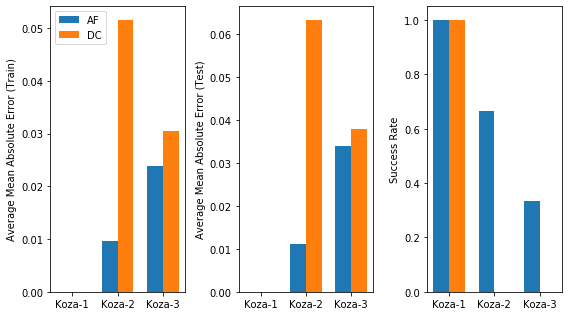

In [9]:
# plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4.5))

mae_test_dc = []
mae_train_dc = []
success_rate_dc = []
for train, test in zip(train_scores_dc, test_scores_dc):
    avg_train = np.mean(np.array(train), axis=0)
    avg_test = np.mean(np.array(test), axis=0)
    mae_train_dc.append(avg_train[0])
    success_rate_dc.append(avg_train[1])
    mae_test_dc.append(avg_test[0])
    
labels = [bench.name for bench in suite]
label_locations = np.arange(len(labels))
bar_width = 0.35
_ = ax1.bar(label_locations - bar_width/2, mae_train_af, bar_width, label='AF')
_ = ax1.bar(label_locations + bar_width/2, mae_train_dc, bar_width, label='DC')

_ = ax2.bar(label_locations - bar_width/2, mae_test_af, bar_width)
_ = ax2.bar(label_locations + bar_width/2, mae_test_dc, bar_width)

_ = ax3.bar(label_locations - bar_width/2, success_rate_af, bar_width)
_ = ax3.bar(label_locations + bar_width/2, success_rate_dc, bar_width)

ax1.set_ylabel('Average Mean Absolute Error (Train)')
ax1.set_xticks(label_locations)
ax1.set_xticklabels(labels)
ax1.legend()
ax2.set_ylabel('Average Mean Absolute Error (Test)')
ax2.set_xticks(label_locations)
ax2.set_xticklabels(labels)
ax3.set_ylabel('Success Rate')
ax3.set_xticks(label_locations)
ax3.set_xticklabels(labels)
fig.tight_layout()